In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def prepare_data(df: pd.DataFrame, target_col: str):
    """
    Split features and target, then create train/test sets.
    """
    features = [
        'Global_active_power', 'Global_intensity',
        'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
        'hour', 'day_of_week', 'month'
    ]
    X = df[features]
    y = df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )
    
    return X_train, X_test, y_train, y_test

def evaluate_model(model, X_test, y_test):
    """
    Print evaluation metrics for regression model.
    """
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    return rmse, r2

def train_linear_regression(X_train, y_train):
    """
    Train a Linear Regression model in a pipeline with scaling.
    """
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])
    pipeline.fit(X_train, y_train)
    return pipeline

def train_random_forest(X_train, y_train):
    """
    Train a Random Forest model.
    """
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model



In [4]:
# Load processed data
import pandas as pd
path = "/Users/zakarianadir/ml-research-portfolio/data/processed_data.csv"
data = pd.read_csv(path)
df = data.sample(1000)
print(data.shape)
df.head()


(2075259, 26)


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_total,Apparent_power,...,Global_intensity_lag1,Global_active_power_lag5,Global_reactive_power_lag5,Global_intensity_lag5,Global_active_power_lag10,Global_reactive_power_lag10,Global_intensity_lag10,Global_active_power_lag15,Global_reactive_power_lag15,Global_intensity_lag15
2066150,2010-11-20 13:14:00,2.636,0.000,239.46,11.0,38.0,0.0,0.0,38.0,2.634060,...,11.0,2.734,0.136,11.4,0.466,0.074,2.0,0.484,0.054,2.0
1633673,2010-01-24 05:17:00,0.268,0.000,245.98,1.0,0.0,0.0,1.0,1.0,0.245980,...,1.2,0.304,0.000,1.2,0.342,0.076,1.4,0.362,0.056,1.6
925334,2008-09-19 07:38:00,1.664,0.000,241.17,6.8,0.0,0.0,19.0,19.0,1.639956,...,6.8,1.658,0.000,6.8,1.694,0.066,7.0,1.778,0.200,7.4
49065,2007-01-19 19:09:00,1.356,0.126,237.34,5.6,0.0,0.0,0.0,0.0,1.329104,...,5.8,1.326,0.000,5.6,1.234,0.000,5.2,1.268,0.000,5.4
1986966,2010-09-26 13:30:00,0.146,0.048,242.40,0.6,0.0,0.0,1.0,1.0,0.145440,...,0.6,0.146,0.048,0.6,0.146,0.048,0.6,0.146,0.048,0.6


In [ ]:
# 1️⃣ Predict Reactive Power
print("\n--- Predicting Global Reactive Power ---")
X_train, X_test, y_train, y_test = prepare_data(df, 'Global_reactive_power')
    
lin_model = train_linear_regression(X_train, y_train)
rf_model = train_random_forest(X_train, y_train)
    
print("\nLinear Regression Results:")
evaluate_model(lin_model, X_test, y_test)

print("\nRandom Forest Results:")
evaluate_model(rf_model, X_test, y_test)

# 2️⃣ Predict Voltage (optional)
print("\n--- Predicting Voltage ---")
X_train_v, X_test_v, y_train_v, y_test_v = prepare_data(df, 'Voltage')
    
rf_model_v = train_random_forest(X_train_v, y_train_v)
evaluate_model(rf_model_v, X_test_v, y_test_v)


--- Predicting Global Reactive Power ---

Linear Regression Results:
RMSE: 0.0982
R²: 0.2415

Random Forest Results:
RMSE: 0.0542
R²: 0.7687

--- Predicting Voltage ---
RMSE: 1.4965
R²: 0.7862


(np.float64(1.4965279996430245), 0.7862460021531239)

In [31]:
# ===========================
# Neural Network Regressor
# ===========================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 1- Dataset preparation
# ---------------------------

class PowerDataset(Dataset):
    def __init__(self, df, feature_cols, target_col, scaler=None, fit_scaler=True):
        X = df[feature_cols].values.astype(np.float32)
        y = df[target_col].values.astype(np.float32).reshape(-1, 1)

        if scaler is None:
            scaler = StandardScaler()
            if fit_scaler:
                X = scaler.fit_transform(X)
        else:
            X = scaler.transform(X)

        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.scaler = scaler

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

    

In [20]:
# ---------------------------
# 2- Model definition
# ---------------------------

class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

In [22]:
# ---------------------------
# 3- Train / Eval utilities
# ---------------------------

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
    return running_loss / len(dataloader.dataset)

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds_all, y_all = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = criterion(preds, y)
            running_loss += loss.item() * X.size(0)
            preds_all.append(preds.cpu().numpy())
            y_all.append(y.cpu().numpy())

    preds_all = np.vstack(preds_all)
    y_all = np.vstack(y_all)
    mse = mean_squared_error(y_all, preds_all)
    mae = mean_absolute_error(y_all, preds_all)
    r2 = r2_score(y_all, preds_all)
    return running_loss / len(dataloader.dataset), mse, mae, r2

In [23]:
# ---------------------------
# 4- Training procedure
# ---------------------------

# Example target
target_col = "Global_reactive_power"

# Feature columns — everything except target and datetime
all_cols = ['datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Sub_total', 'Apparent_power', 'Power_factor',
       'month', 'hour', 'day_of_week', 'Global_active_power_lag1',
       'Global_reactive_power_lag1', 'Global_intensity_lag1',
       'Global_active_power_lag5', 'Global_reactive_power_lag5',
       'Global_intensity_lag5', 'Global_active_power_lag10',
       'Global_reactive_power_lag10', 'Global_intensity_lag10',
       'Global_active_power_lag15', 'Global_reactive_power_lag15',
       'Global_intensity_lag15']

exclude_cols = ['datetime', 'Voltage', 'Global_active_power_lag1',
       'Global_reactive_power_lag1', 'Global_intensity_lag1',
       'Global_active_power_lag5', 'Global_reactive_power_lag5',
       'Global_intensity_lag5', 'Global_active_power_lag10',
       'Global_reactive_power_lag10', 'Global_intensity_lag10',
       'Global_active_power_lag15', 'Global_reactive_power_lag15',
       'Global_intensity_lag15', target_col]

feature_cols = [c for c in df.columns if c not in exclude_cols]

# Create dataset
full_dataset = PowerDataset(df, feature_cols, target_col)
scaler = full_dataset.scaler

# Split into train / test (80-20)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model, optimizer, loss
model = MLPRegressor(input_dim=len(feature_cols)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
n_epochs = 25
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, mse, mae, r2 = eval_epoch(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1:02d}/{n_epochs} | Train Loss: {train_loss:.4f} | Val RMSE: {np.sqrt(mse):.4f} | R²: {r2:.4f}")


Using device: cpu
Epoch 01/25 | Train Loss: 0.0439 | Val RMSE: 0.1714 | R²: -1.1816
Epoch 02/25 | Train Loss: 0.0269 | Val RMSE: 0.1499 | R²: -0.6691
Epoch 03/25 | Train Loss: 0.0159 | Val RMSE: 0.1560 | R²: -0.8061
Epoch 04/25 | Train Loss: 0.0134 | Val RMSE: 0.1524 | R²: -0.7249
Epoch 05/25 | Train Loss: 0.0117 | Val RMSE: 0.1304 | R²: -0.2617
Epoch 06/25 | Train Loss: 0.0107 | Val RMSE: 0.1149 | R²: 0.0201
Epoch 07/25 | Train Loss: 0.0106 | Val RMSE: 0.1099 | R²: 0.1041
Epoch 08/25 | Train Loss: 0.0093 | Val RMSE: 0.1067 | R²: 0.1542
Epoch 09/25 | Train Loss: 0.0095 | Val RMSE: 0.1071 | R²: 0.1487
Epoch 10/25 | Train Loss: 0.0087 | Val RMSE: 0.1081 | R²: 0.1321
Epoch 11/25 | Train Loss: 0.0080 | Val RMSE: 0.1055 | R²: 0.1744
Epoch 12/25 | Train Loss: 0.0075 | Val RMSE: 0.1037 | R²: 0.2012
Epoch 13/25 | Train Loss: 0.0078 | Val RMSE: 0.0988 | R²: 0.2747
Epoch 14/25 | Train Loss: 0.0080 | Val RMSE: 0.1022 | R²: 0.2245
Epoch 15/25 | Train Loss: 0.0078 | Val RMSE: 0.1096 | R²: 0.1083
Ep

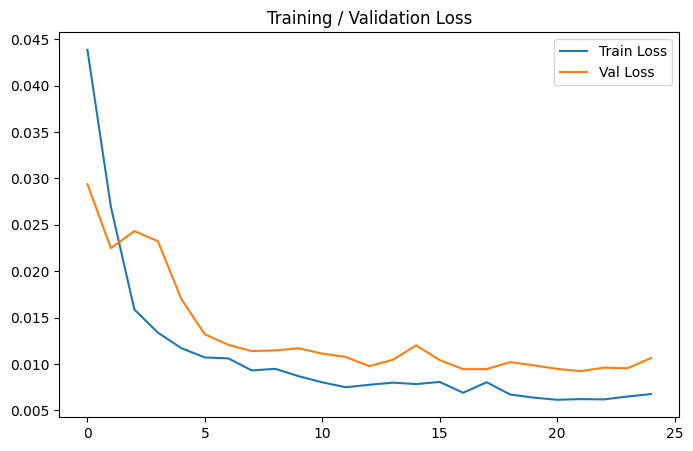


Final Evaluation:
  RMSE = 0.1032
  MAE = 0.0763
  R² = 0.2098


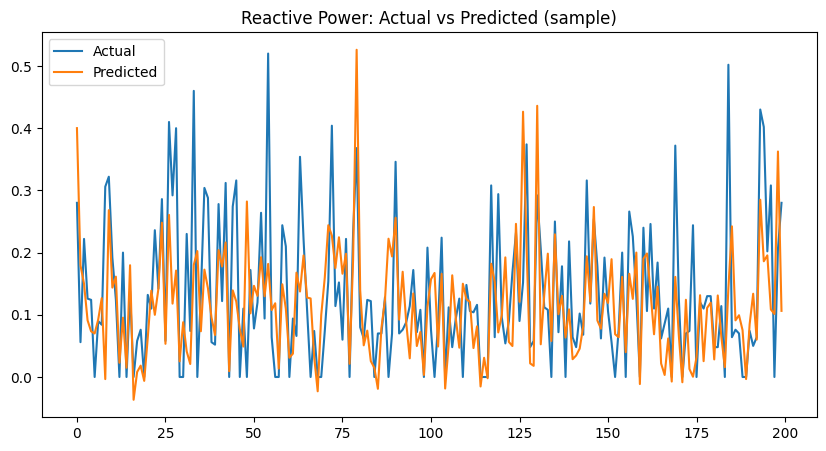

In [24]:
# Plot training curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Training / Validation Loss")
plt.legend()
plt.show()

# Final metrics
val_loss, mse, mae, r2 = eval_epoch(model, test_loader, criterion, device)
print(f"\nFinal Evaluation:\n  RMSE = {np.sqrt(mse):.4f}\n  MAE = {mae:.4f}\n  R² = {r2:.4f}")

# Example: visualize a subset of predictions vs actuals
model.eval()
X_batch, y_batch = next(iter(test_loader))
with torch.no_grad():
    preds = model(X_batch.to(device)).cpu().numpy()

plt.figure(figsize=(10,5))
plt.plot(y_batch.numpy()[:200], label='Actual')
plt.plot(preds[:200], label='Predicted')
plt.title("Reactive Power: Actual vs Predicted (sample)")
plt.legend()
plt.show()